In [1]:
import numpy as np
np.random.seed(0)

# IROS for dummies

In this notebook we try to understand how the fuck IROS works, by applying it "manually" to a bare bone coded mask simulation.

First let's generate a mask, we will use a reasonably sized URA mask, because they are the easiest to deal with.
The mask is obtained padding the URA tile to its borders so that the mask has lengths double the size of the detector.
We only consider sources in the fully-coded field of view.

In [2]:
import masks

mask_size = (61, 59)
mask, decoder = masks.ura(*mask_size)
padded_mask = masks.pad(mask)

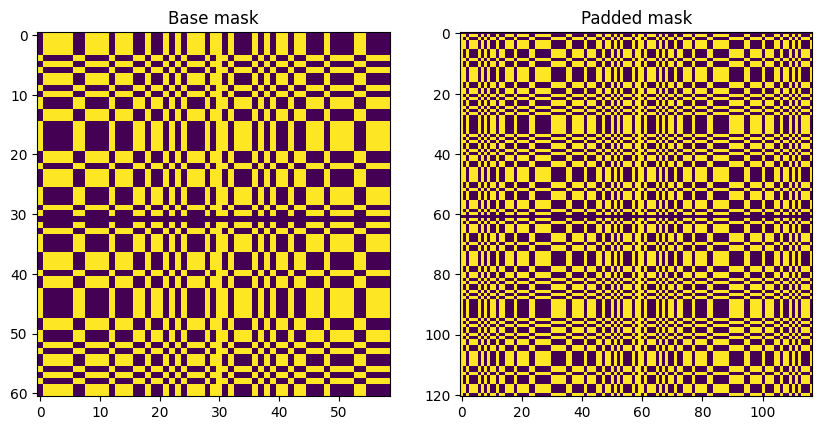

In [4]:
import matplotlib.pyplot as plt
from masks.plot import plotmaps

fig, axs = plotmaps([(mask, "Base mask", ""), (padded_mask, "Padded mask", "")], figsize=(10, 7))
plt.show()

We simulate the photons from three sources with power-law flux distribution, and a constant sky background. The sources directions are chosen at random, so we print them.

In [5]:
from masks import simulate

fsources = [4000, 2000, 1000]  # the source brightness
brate = 1  # the average background count per mask element
photon_list, info = simulate.photon_list(
    fsources =  fsources,
    brate = brate, 
    shape = mask_size
)
print(f"I have generated {len(ds := info['source_directions'])} sources at the sky coordinates: {', '.join(map(str, ds))}")

I have generated 3 sources at the sky coordinates: [26 33], [49 30], [ 3 33]


Now that we have the photons, we can simulate the sky maps, both before the mask and after mask absorption. Sky-map after mask has halved counts due to the URA open fraction.

In [6]:
skymap_before_mask = simulate.skymap(photon_list, mask_size)
skymap_after_mask = simulate.skymap_transmitted(photon_list, mask)

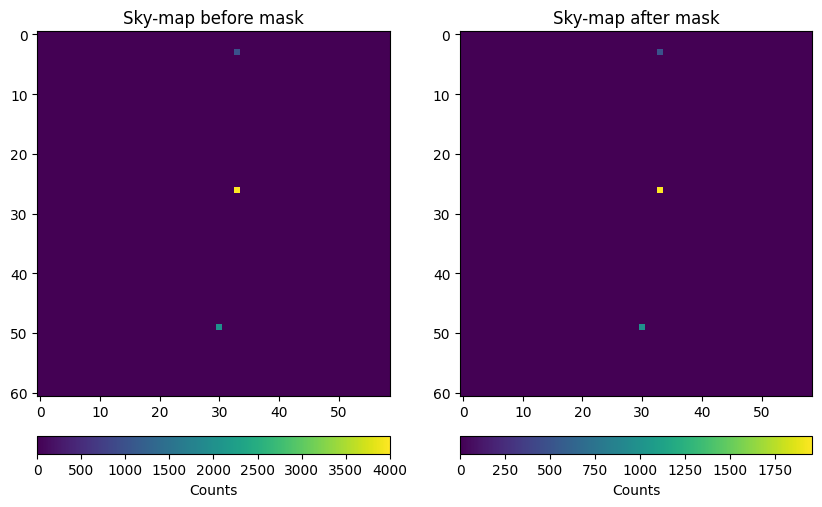

In [7]:
fig, axs = plotmaps(
    [(skymap_before_mask, "Sky-map before mask", "Counts"),
     (skymap_after_mask, "Sky-map after mask", "Counts")],
    figsize=(10,7)
)
plt.show()

We can also compute the true statistical significance of the sources and plot a significance map.

In [8]:
import warnings
import numpy as np
from masks import stats

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sign = np.nan_to_num(stats.significance(skymap_before_mask, 1))

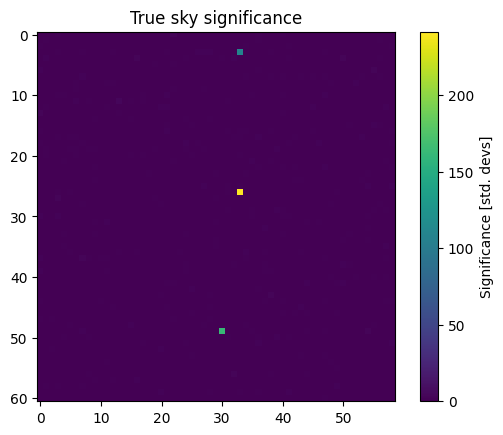

In [9]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(sign)
fig.colorbar(c0, ax=ax, label="Significance [std. devs]")
ax.set_title("True sky significance")
plt.show()

We have just fiddled with the parameter simulation for the last time. We will not use them in our analysis but will later check our results against them.

Let's transport the simulated photons from the mask to the detector and generate the detector hit map.

In [10]:
detector = simulate.transport(photon_list, mask)

# since we will overwrite `detector` we store the original image in a separate variable
detector_ = detector.copy()

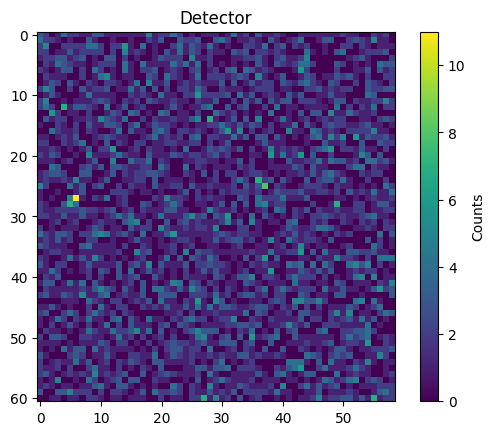

In [11]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts")
ax.set_title("Detector")
plt.show()

From the detector hitmap we derive the sky image reconstructed via cross-correlation.

In [12]:
from masks import reconstruct

skymap_cc = reconstruct.cross_correlation(detector, decoder)

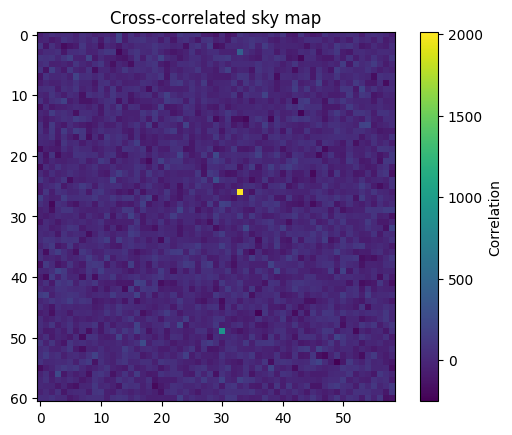

In [13]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(skymap_cc)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Cross-correlated sky map")
plt.show()

Now we compute the significance of the sources in the reconstructed image. They are MUCH less significative then we estimated from the true values! 

In [14]:
import numpy as np

from masks import stats

variance_cc = stats.variance(detector, decoder)
snr_cc = skymap_cc / np.sqrt(variance_cc)

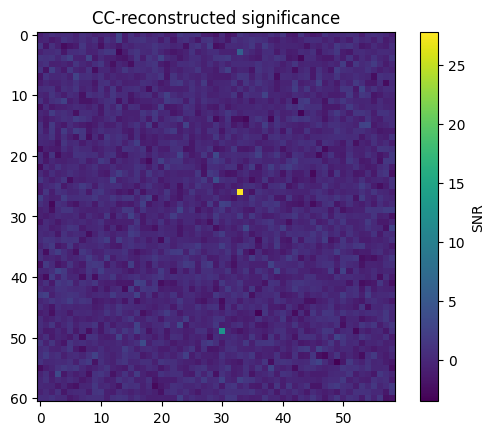

In [15]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(snr_cc)
fig.colorbar(c0, ax=ax, label="SNR")
ax.set_title("CC-reconstructed significance")
plt.show()

You can go on, here I'm just setting some auxiliary code.

In [16]:
source_bucket = []

def record_source(source, skymap_cc):
    x, y, counts = *source, skymap_cc[*source]
    source_bucket.append({
        "x": source[0].item(),
        "y": source[1].item(),
        "counts": counts.item(),
    })

def get_sources():
    return source_bucket

# First pass

Let's start identifying the most brilliant source in the sky image reconstructed by cross-correlation. To achieve this we must first set a significance threshold. To settle on a threshold it is a good idea to first check the normality of the values in cc-reconstructed image.

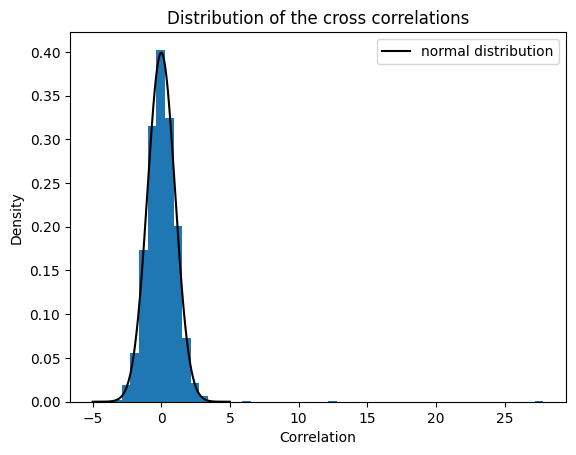

In [17]:
from scipy.stats import norm

plt.hist(snr_cc.reshape(-1), bins=50, density= True)
plt.plot(x:= np.linspace(-5, +5, 1000), norm.pdf(x), color="k", label="normal distribution")
plt.title("Distribution of the cross correlations")
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.legend()
plt.show()

Lovely, I don't think there is need for a quantitative test: they follow a nice normal distribution as one would expect. Let's select the sources over 5 sigma threshold, we have three:

In [18]:
import pandas as pd

threshold = 5.0

sources = np.argwhere(snr_cc > 5.0)
pd.DataFrame(zip(*sources.T, snr_cc[*sources.T]), columns=["x", "y", "SNR [σ]"])

,x,y,SNR [σ]
0,3,33,5.978815
1,26,33,27.822894
2,49,30,12.578986


We take the most significant source and build a shadowgram for it.

In [19]:
source = sources[np.argmax(snr_cc[*sources.T])]; record_source(source, skymap_cc)

In [20]:
def shadowgram(x, y, counts, mask):
    s = np.zeros(mask_size)
    s[x, y] = counts 
    return masks.encode(s, mask)

source_shadowgram = shadowgram(*source, skymap_cc[*source], mask)

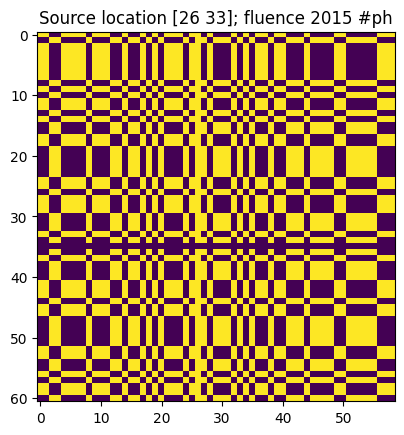

In [21]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(source_shadowgram)
ax.set_title(f"Source location {source}; fluence {skymap_cc[*source]:.0f} #ph")
plt.show()

Now let's subtract this shadowgram to the detector image and decode the result.

In [22]:
detector = detector - source_shadowgram
skymap_cc = reconstruct.cross_correlation(detector, decoder)
variance_cc = stats.variance(skymap_cc, decoder)
snr_cc = skymap_cc/ np.sqrt(variance_cc)

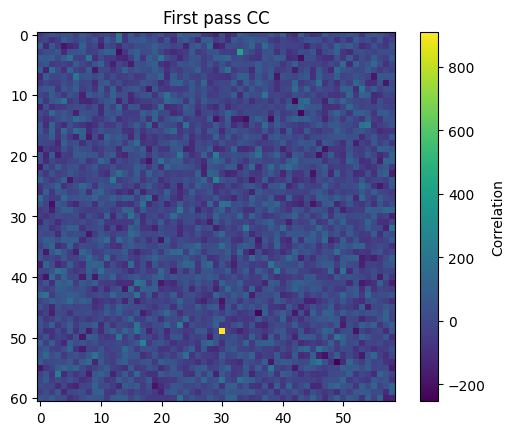

In [23]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(skymap_cc)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("First pass CC")
plt.show()

# Second pass

After the first pass, the statistics gets worse, which is unsurprising given that we subtracted to count data.

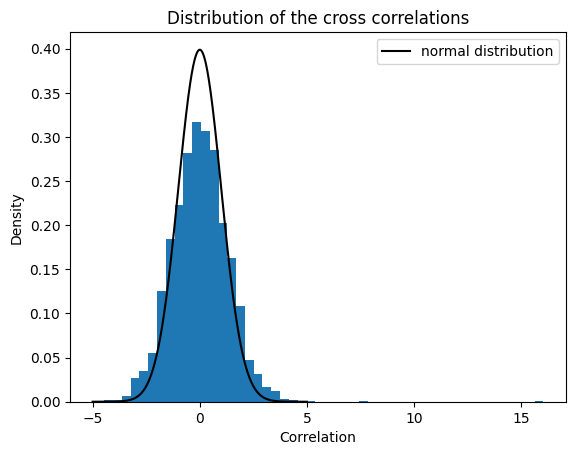

In [24]:
from scipy.stats import norm

plt.hist(snr_cc.reshape(-1), bins=50, density= True)
plt.plot(x:= np.linspace(-5, +5, 1000), norm.pdf(x), color="k", label="normal distribution")
plt.title("Distribution of the cross correlations")
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.legend()
plt.show()

Let's get the source above threshold.

In [25]:
sources = np.argwhere(snr_cc > 5.)
pd.DataFrame(zip(*sources.T, snr_cc[*sources.T]), columns=["x", "y", "SNR [σ]"])

,x,y,SNR [σ]
0,3,33,7.618801
1,49,30,16.029394


Rinse and repeat: we isolate the most significant of the remaining sources, estimate its flux from the cc-reconstructed sky map after the first clean up, generate its shadowgram and subtract it to the (one pass) cleaned detector image.  

In [26]:
source = sources[np.argmax(snr_cc[*sources.T])]
record_source(source, skymap_cc)

In [27]:
source_shadowgram = shadowgram(*source, skymap_cc[*source], mask)
detector = detector - source_shadowgram
skymap_cc = reconstruct.cross_correlation(detector, decoder)
variance_cc = stats.variance(skymap_cc, decoder)
snr_cc = skymap_cc/ np.sqrt(variance_cc)

This is the cc-reconstructed sky image after the second cleaning pass.

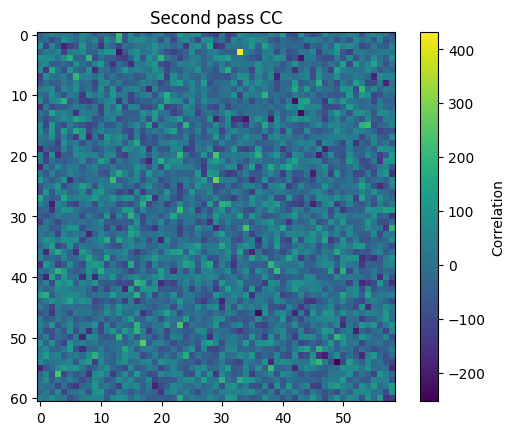

In [28]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(skymap_cc)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Second pass CC")
plt.show()

# Third pass

Statistics is really going to hell now.

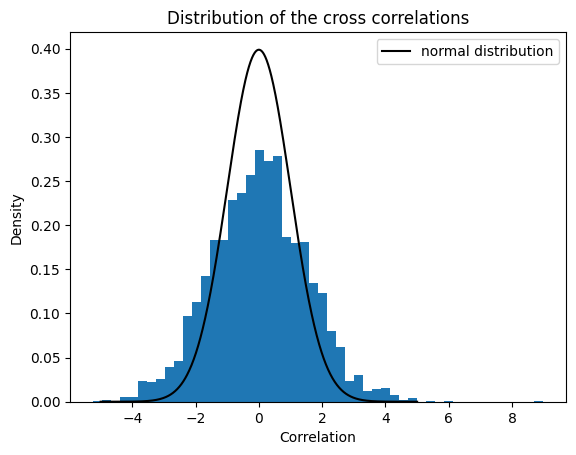

In [29]:
from scipy.stats import norm

plt.hist(snr_cc.reshape(-1), bins=50, density= True)
plt.plot(x:= np.linspace(-5, +5, 1000), norm.pdf(x), color="k", label="normal distribution")
plt.title("Distribution of the cross correlations")
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.legend()
plt.show()

Note that the number of sources over threshold is still three (we would like to have only one). This is because the cross-correlation statistics is now messed up by the shadowgrams subtractions, and very, very far from normal. It will make for a serious issue when "wrapping" up the program, because it will make harder to decide when to actually break out of the cleaning loop. 

In [30]:
sources = np.argwhere(snr_cc > 5.0)
pd.DataFrame(zip(*sources.T, snr_cc[*sources.T]), columns=["x", "y", "SNR [σ]"])

,x,y,SNR [σ]
0,3,33,8.991611
1,24,29,5.876734
2,51,17,5.419886


Rinse and repeat once again.

In [31]:
source = sources[np.argmax(snr_cc[*sources.T])]
record_source(source, skymap_cc)

In [32]:
source_shadowgram = shadowgram(*source, skymap_cc[*source], mask)
detector = detector - source_shadowgram
skymap_cc = reconstruct.cross_correlation(detector, decoder)
variance_cc = stats.variance(skymap_cc, decoder)
snr_cc = skymap_cc/ np.sqrt(variance_cc)

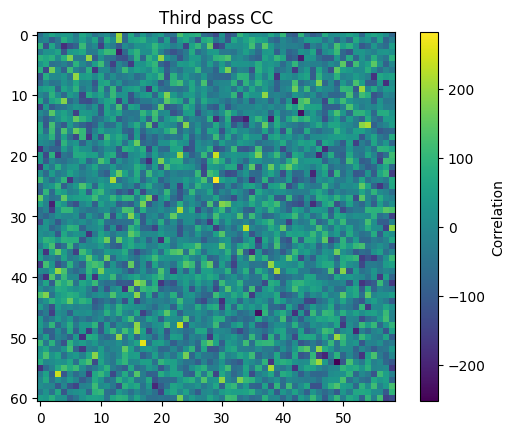

In [33]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(skymap_cc)
fig.colorbar(c0, ax=ax, label="Correlation")
ax.set_title("Third pass CC")
plt.show()

# Image reconstruction

With some paraculaggine we break out of the loop here. This is only because we know we generate three sources. In a real scenario we would continue iterating because of the statistics fuck up we saw just before. *We are missing a rule to adjust the threshold to actually reach the break condition*.

Anyway. Let's give a look what we have got on the reconstructed sources:

In [34]:
sources = get_sources()
pd.DataFrame(sources)

,x,y,counts
0,26,33,2015.0
1,49,30,911.0
2,3,33,433.0


Which compares decently to the true values, after adjusting by the open fraction.

In [35]:
f = masks.open_fraction(mask)
pd.DataFrame({"true counts": np.array(fsources) * f})

,true counts
0,2000.555710
1,1000.277855
2,500.138927


We estimate the background rate by subtracting the total detector counts by the sum of the counts from the recovered sources.

In [36]:
estimated_brate = (np.sum(detector_) - sum([source["counts"] for source in sources])) / np.prod(mask_size)
print(f"i'm estimating a backround flux of {estimated_brate:.2f} counts per mask element")

i'm estimating a backround flux of 0.52 counts per mask element


Which again is consistent with the true value:

In [37]:
print(f"true backround flux was {brate * f:.2f} counts per mask element")

true backround flux was 0.50 counts per mask element


Finally let's put these information together in a reconstructed picture:

In [38]:
skymap_iros = np.ones(mask.shape) * brate
for source in sources:
    skymap_iros[source["x"], source["y"]] = source["counts"] / f

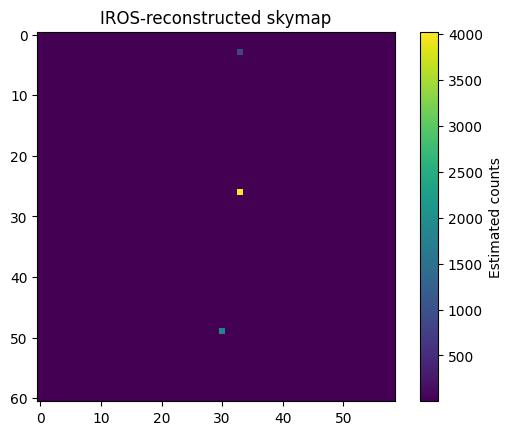

In [39]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(skymap_iros)
fig.colorbar(c0, ax=ax, label="Estimated counts")
ax.set_title("IROS-reconstructed skymap")
plt.show()

## Comparison with other reconstruction methods

Let's compare the result with other methods.

In [40]:
from masks import reconstruct

skymap_cc = reconstruct.cross_correlation(detector_, decoder)  / f
skymap_mlemrec = reconstruct.mlem(detector_, mask)  / f
skymap_mem, _ = reconstruct.mem(detector_, mask, decoder)
skymap_mem /= f

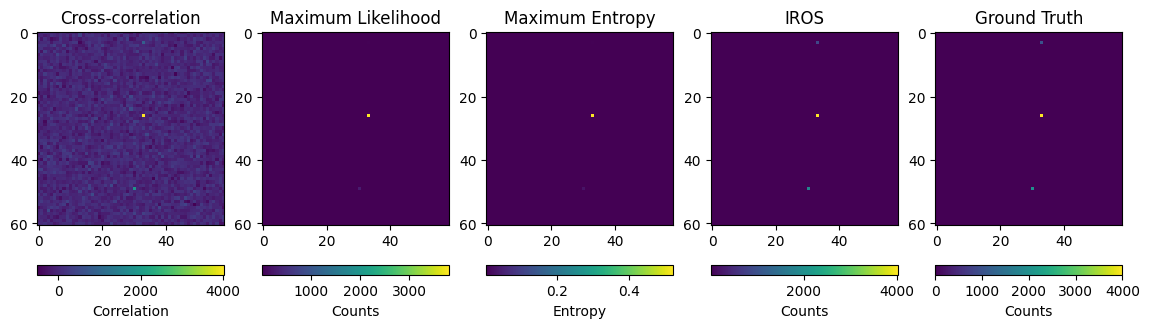

In [41]:
fig, axs = plotmaps(
    [
        (skymap_cc, "Cross-correlation", "Correlation"),
        (skymap_mlemrec, "Maximum Likelihood", "Counts"),
        (skymap_mem, "Maximum Entropy", "Entropy"),
        (skymap_iros, "IROS", "Counts"),
        (skymap_before_mask, "Ground Truth", "Counts"),
    ],
    ncols=5,
    figsize=(14, 7),
)
plt.show()